# The Sparks Foundation- Task 4 Stock Market Prediction using Numerical and Texual Analysis 

**The given problem statement includes Texual analysis of the news headlines as well as numerical analysis, that is analysis of the stock prices on a parcticular day for the purpose of stock market prediction and to determnine its trend** 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBClassifier

**First of all we will download the texual data from https://bit.ly/36fFPI6**

In [2]:
news = pd.read_csv("india-news-headlines.csv")
print(news.shape)
print(news.columns)
news.head(20)

(1048575, 3)
Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')


,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
5,20010102,unknown,Extra buses to clear tourist traffic
6,20010102,unknown,Dilute the power of transfers; says Riberio
7,20010102,unknown,Focus shifts to teaching of Hindi
8,20010102,unknown,IT will become compulsory in schools
9,20010102,unknown,Move to stop freedom fighters' pension flayed


In [3]:
news=news.drop(['headline_category'], axis=1)

**In order to actually use the headlines to determine its effect on the stock prices we need to first do the sentimental analysis using NLP which would quantify the headlines with attributes : negative, positive and neutral**
**For sentiment analysis we would be using ‘nltk.sentiment.vader’ library** 

In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [5]:
scores = news['headline_text'].apply(vader.polarity_scores).tolist()

In [6]:
scores_df = pd.DataFrame(scores)

**Here the Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive)**

In [7]:
news = news.join(scores_df, rsuffix='_right')
news.head()

,publish_date,headline_text,neg,neu,pos,compound
0,20010101,win over cena satisfying but defeating underta...,0.230,0.473,0.297,-0.0000
1,20010102,Status quo will not be disturbed at Ayodhya; s...,0.000,0.805,0.195,0.2924
2,20010102,Fissures in Hurriyat over Pak visit,0.000,1.000,0.000,0.0000
3,20010102,America's unwanted heading for India?,0.322,0.678,0.000,-0.2263
4,20010102,For bigwigs; it is destination Goa,0.000,1.000,0.000,0.0000


**Now, if you observe we have multiple headlines for same date in our dataset. We need to average the sentiment score of all the headlines of same date for an overall evaluation**

In [8]:
mean_scores = news.groupby(['publish_date']).mean()

In [9]:
mean_scores=pd.DataFrame(mean_scores)
mean_scores.head()

,neg,neu,pos,compound
publish_date,,,,
20010101,0.230000,0.473000,0.297000,0.000000
20010102,0.096756,0.831279,0.071965,-0.018231
20010103,0.100805,0.812244,0.086976,-0.014800
20010104,0.076235,0.838464,0.085294,0.009842
20010105,0.098810,0.772841,0.128333,0.028646


In [10]:
mean_test=mean_scores
mean_test.index

Int64Index([20010101, 20010102, 20010103, 20010104, 20010105, 20010106,
            20010107, 20010108, 20010109, 20010110,
            ...
            20110129, 20110130, 20110131, 20110201, 20110202, 20110203,
            20110204, 20110205, 20110206, 20110207],
           dtype='int64', name='publish_date', length=3649)

**The publish date is in the string format but in order to join the texual data with the numerical data we need to convert the date from string to date**

In [11]:
list1=list(map(str,mean_test.index))
list2=[]
for i in list1:
    list2.append(i[0:4]+'/'+i[4:6]+'/'+i[6:])
list2

['2001/01/01',
 '2001/01/02',
 '2001/01/03',
 '2001/01/04',
 '2001/01/05',
 '2001/01/06',
 '2001/01/07',
 '2001/01/08',
 '2001/01/09',
 '2001/01/10',
 '2001/01/11',
 '2001/01/23',
 '2001/01/24',
 '2001/01/25',
 '2001/01/26',
 '2001/01/27',
 '2001/01/28',
 '2001/01/29',
 '2001/01/30',
 '2001/01/31',
 '2001/02/01',
 '2001/02/02',
 '2001/02/03',
 '2001/02/04',
 '2001/02/05',
 '2001/02/06',
 '2001/02/07',
 '2001/02/08',
 '2001/02/09',
 '2001/02/10',
 '2001/02/11',
 '2001/02/12',
 '2001/02/13',
 '2001/02/14',
 '2001/02/15',
 '2001/02/16',
 '2001/02/17',
 '2001/02/18',
 '2001/02/19',
 '2001/02/21',
 '2001/02/22',
 '2001/02/23',
 '2001/02/24',
 '2001/02/25',
 '2001/02/26',
 '2001/02/27',
 '2001/02/28',
 '2001/03/01',
 '2001/03/02',
 '2001/03/05',
 '2001/03/09',
 '2001/03/11',
 '2001/03/13',
 '2001/03/14',
 '2001/03/15',
 '2001/03/16',
 '2001/03/17',
 '2001/03/18',
 '2001/03/19',
 '2001/03/20',
 '2001/03/21',
 '2001/03/22',
 '2001/03/23',
 '2001/03/25',
 '2001/03/26',
 '2001/03/27',
 '2001/03/

In [12]:
mean_test['date']=list2
mean_test.head()

,neg,neu,pos,compound,date
publish_date,,,,,
20010101,0.230000,0.473000,0.297000,0.000000,2001/01/01
20010102,0.096756,0.831279,0.071965,-0.018231,2001/01/02
20010103,0.100805,0.812244,0.086976,-0.014800,2001/01/03
20010104,0.076235,0.838464,0.085294,0.009842,2001/01/04
20010105,0.098810,0.772841,0.128333,0.028646,2001/01/05


In [13]:
mean_test['date']=pd.to_datetime(mean_test['date'])
mean_test.head()

,neg,neu,pos,compound,date
publish_date,,,,,
20010101,0.230000,0.473000,0.297000,0.000000,2001-01-01
20010102,0.096756,0.831279,0.071965,-0.018231,2001-01-02
20010103,0.100805,0.812244,0.086976,-0.014800,2001-01-03
20010104,0.076235,0.838464,0.085294,0.009842,2001-01-04
20010105,0.098810,0.772841,0.128333,0.028646,2001-01-05


In [19]:
mean_test.to_csv("headline_sentiment_score1.csv")

**After the texual analysis now we will analyse the numerical data**

**You can download the numerical data from finance.yahoo.com**

In [20]:
stock = pd.read_csv("numerical_data.csv")
print(stock.shape)from finance.yahoo.com
print(stock.columns)
stock.head(20)

(2553, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2001,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0
1,1/3/2001,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0
2,1/4/2001,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0
3,1/5/2001,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0
4,1/8/2001,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0
5,1/9/2001,4114.740234,4166.839844,4101.009766,4125.310059,4125.310059,0.0
6,1/10/2001,4151.580078,4155.859863,4035.439941,4047.639893,4047.639893,0.0
7,1/11/2001,4066.129883,4077.540039,4006.540039,4027.129883,4027.129883,0.0
8,1/12/2001,4059.409912,4082.770020,4018.280029,4036.580078,4036.580078,0.0
9,1/15/2001,4074.320068,4080.139893,4018.239990,4046.760010,4046.760010,0.0


In [21]:
stock['Date']=pd.to_datetime(stock['Date'])
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0


In [23]:
news = pd.read_csv("headline_sentiment_score1.csv")
news['Date']=pd.to_datetime(news['Date'])
print(news.shape)
print(news.columns)
news.head(20)

(3649, 6)
Index(['publish_date', 'neg', 'neu', 'pos', 'compound', 'Date'], dtype='object')


,publish_date,neg,neu,pos,compound,Date
0,20010101,0.230000,0.473000,0.297000,0.000000,2001-01-01
1,20010102,0.096756,0.831279,0.071965,-0.018231,2001-01-02
2,20010103,0.100805,0.812244,0.086976,-0.014800,2001-01-03
3,20010104,0.076235,0.838464,0.085294,0.009842,2001-01-04
4,20010105,0.098810,0.772841,0.128333,0.028646,2001-01-05
5,20010106,0.108167,0.768917,0.122917,-0.019683,2001-01-06
6,20010107,0.097642,0.883537,0.018821,-0.091213,2001-01-07
7,20010108,0.098348,0.819682,0.081970,-0.055812,2001-01-08
8,20010109,0.126143,0.830099,0.043758,-0.088437,2001-01-09
9,20010110,0.262500,0.737500,0.000000,-0.221975,2001-01-10


**Now we will merge the texual data and the numerical data by using inner join on Date**

In [24]:
merged_data = news.merge(stock,how='inner', on='Date') 
print(merged_data.shape)
print(merged_data.columns)
merged_data.head(20)

(2524, 12)
Index(['publish_date', 'neg', 'neu', 'pos', 'compound', 'Date', 'Open', 'High',
       'Low', 'Close', 'Adj Close', 'Volume'],
      dtype='object')


,publish_date,neg,neu,pos,compound,Date,Open,High,Low,Close,Adj Close,Volume
0,20010102,0.096756,0.831279,0.071965,-0.018231,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0
1,20010103,0.100805,0.812244,0.086976,-0.014800,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0
2,20010104,0.076235,0.838464,0.085294,0.009842,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0
3,20010105,0.098810,0.772841,0.128333,0.028646,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0
4,20010108,0.098348,0.819682,0.081970,-0.055812,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0
5,20010109,0.126143,0.830099,0.043758,-0.088437,2001-01-09,4114.740234,4166.839844,4101.009766,4125.310059,4125.310059,0.0
6,20010110,0.262500,0.737500,0.000000,-0.221975,2001-01-10,4151.580078,4155.859863,4035.439941,4047.639893,4047.639893,0.0
7,20010111,0.102500,0.821000,0.076500,0.000000,2001-01-11,4066.129883,4077.540039,4006.540039,4027.129883,4027.129883,0.0
8,20010123,0.036823,0.899871,0.063306,0.024994,2001-01-23,4277.830078,4321.750000,4272.870117,4296.689941,4296.689941,0.0
9,20010124,0.084511,0.811844,0.103622,0.012122,2001-01-24,4320.509766,4339.410156,4295.709961,4326.419922,4326.419922,0.0


In [25]:
merged_data=merged_data.drop(['publish_date'], axis=1)

In [26]:
merged_data.to_csv("merged_data.csv")

**Plotted histograms for individual columns to see the distribution of values.**

**The x axis is the column values and the y axis is the frequency of those values.**

**The plot below gives a fair idea of how the data is distributed across columns. We can see that most of the columns though not normally distributed are fairly evenly distributed across all the columns which is a good sign as we do not have to skew much with the data**

C:\Users\shahp\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\shahp\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


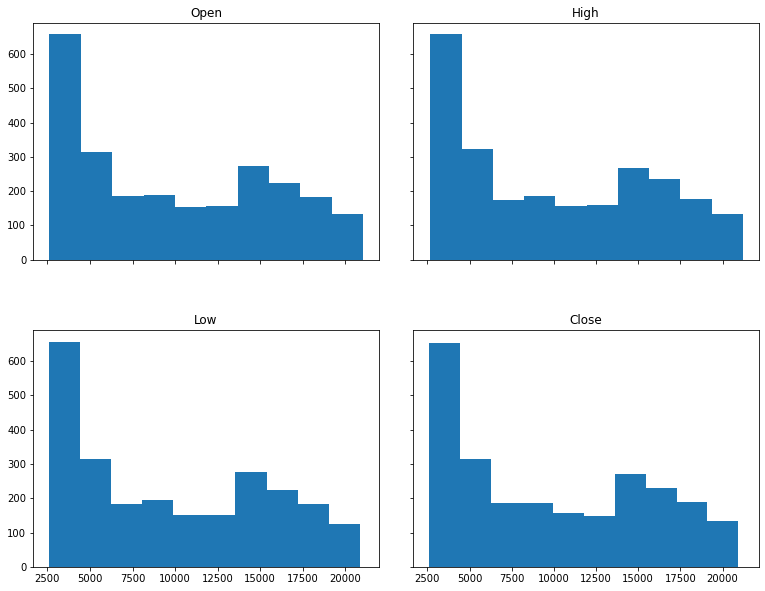

In [27]:
# Histograms for existing columns
cols = list(stock.columns[1:-2])
cnt = 0
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(13, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for i in range(2):
    for j in range(2):
        ax[i, j].hist(merged_data[cols[cnt]])
        ax[i, j].set_title(cols[cnt])
        cnt += 1

In [28]:
merged_data_test=merged_data[['Date','neg','neu','pos','compound','Open','High','Low','Close','Adj Close','Volume']]
merged_data_test.head()

,Date,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.096756,0.831279,0.071965,-0.018231,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0
1,2001-01-03,0.100805,0.812244,0.086976,-0.014800,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0
2,2001-01-04,0.076235,0.838464,0.085294,0.009842,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0
3,2001-01-05,0.098810,0.772841,0.128333,0.028646,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0
4,2001-01-08,0.098348,0.819682,0.081970,-0.055812,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0


In [29]:
merged_data_test=merged_data_test.dropna()

In [30]:
merged_data_test.to_csv("merged_data.csv")

In [31]:
merged_data = pd.read_csv("merged_data.csv")
print(merged_data.shape)
print(merged_data.columns)
merged_data.head(20)

(2467, 12)
Index(['Unnamed: 0', 'Date', 'neg', 'neu', 'pos', 'compound', 'Open', 'High',
       'Low', 'Close', 'Adj Close', 'Volume'],
      dtype='object')


,Unnamed: 0,Date,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume
0,0,2001-01-02,0.096756,0.831279,0.071965,-0.018231,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0
1,1,2001-01-03,0.100805,0.812244,0.086976,-0.014800,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0
2,2,2001-01-04,0.076235,0.838464,0.085294,0.009842,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0
3,3,2001-01-05,0.098810,0.772841,0.128333,0.028646,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0
4,4,2001-01-08,0.098348,0.819682,0.081970,-0.055812,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0
5,5,2001-01-09,0.126143,0.830099,0.043758,-0.088437,4114.740234,4166.839844,4101.009766,4125.310059,4125.310059,0.0
6,6,2001-01-10,0.262500,0.737500,0.000000,-0.221975,4151.580078,4155.859863,4035.439941,4047.639893,4047.639893,0.0
7,7,2001-01-11,0.102500,0.821000,0.076500,0.000000,4066.129883,4077.540039,4006.540039,4027.129883,4027.129883,0.0
8,8,2001-01-23,0.036823,0.899871,0.063306,0.024994,4277.830078,4321.750000,4272.870117,4296.689941,4296.689941,0.0
9,9,2001-01-24,0.084511,0.811844,0.103622,0.012122,4320.509766,4339.410156,4295.709961,4326.419922,4326.419922,0.0


In [32]:
merged_data=merged_data.drop(['Unnamed: 0'],axis=1)

**Finally we have a decent dataset with a combined information about the texual data and the numerical data which we will be further using for prediction purpose**

In [33]:
merged_data.head()

,Date,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.096756,0.831279,0.071965,-0.018231,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0
1,2001-01-03,0.100805,0.812244,0.086976,-0.014800,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0
2,2001-01-04,0.076235,0.838464,0.085294,0.009842,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0
3,2001-01-05,0.098810,0.772841,0.128333,0.028646,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0
4,2001-01-08,0.098348,0.819682,0.081970,-0.055812,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0


**First we will try to classify weather the closing price has increased or decreased with respect to the opening price owing to the headlines that day**



**For that we need to label our data for classification.**

**Here if opening price >= closing price then, label= 1 and if opening price < closing price label=0**

In [34]:
label=[]
for i in merged_data.index:
    if merged_data['Open'][i]>=merged_data['Close'][i]:
        label.append('1')
    else:
        label.append('0')
print(label)

['0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0',

**We will append the labels to our dataframe**

In [35]:
label=pd.DataFrame(label)
merged_data['label']=label
merged_data.head(20)

,Date,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume,label
0,2001-01-02,0.096756,0.831279,0.071965,-0.018231,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0,0
1,2001-01-03,0.100805,0.812244,0.086976,-0.014800,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0,0
2,2001-01-04,0.076235,0.838464,0.085294,0.009842,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0,1
3,2001-01-05,0.098810,0.772841,0.128333,0.028646,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0,0
4,2001-01-08,0.098348,0.819682,0.081970,-0.055812,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0,1
5,2001-01-09,0.126143,0.830099,0.043758,-0.088437,4114.740234,4166.839844,4101.009766,4125.310059,4125.310059,0.0,0
6,2001-01-10,0.262500,0.737500,0.000000,-0.221975,4151.580078,4155.859863,4035.439941,4047.639893,4047.639893,0.0,1
7,2001-01-11,0.102500,0.821000,0.076500,0.000000,4066.129883,4077.540039,4006.540039,4027.129883,4027.129883,0.0,1
8,2001-01-23,0.036823,0.899871,0.063306,0.024994,4277.830078,4321.750000,4272.870117,4296.689941,4296.689941,0.0,0
9,2001-01-24,0.084511,0.811844,0.103622,0.012122,4320.509766,4339.410156,4295.709961,4326.419922,4326.419922,0.0,0


# Correlation Map for features:

**Now we need to check the features and their dependability over each other. For this I plotted a scatter matrix using pearson correlation**

**From the heat map we can conclude that there are very few features that are highly co-related and thus we dont need to use any dimentionality reduction here.**

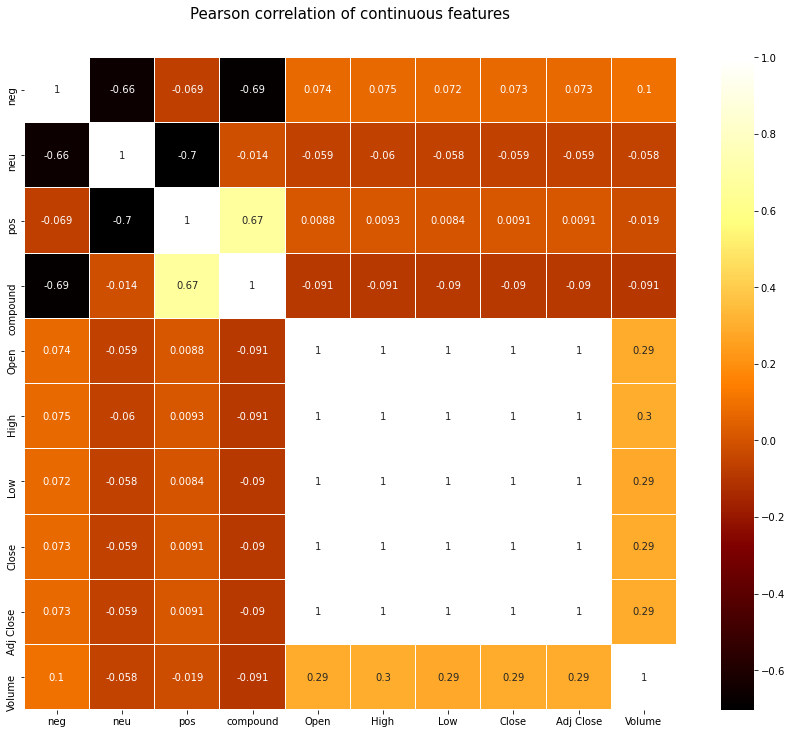

In [36]:
from matplotlib import pyplot
import seaborn as sns
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(merged_data.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

# Classification

**Now we will split the dataset into training data and testing data**


In [38]:
#Storing attribute values in X and target values in Y
X = merged_data.values[:, 1:10] 
Y = merged_data.values[:, 11:12] 
#Spliting the data into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3)


# Logistic Regression

**The first classification technique that we are using is Logistic Regression**

In [39]:
lr = LogisticRegression()
lr.fit(X_train, y_train.ravel())
lr.score(X_test, y_test)

0.9973009446693657

**As we can see we got an accuracy of 0.99 (which is too good to be true :d). Hence, we encountered an issue of overfitting.**

**For that we will scale our data. Getting all the data in all columns to the same range helps better train the model. We can use a method StandardScalar to scale the data.**

In [40]:
# prepare the model LR
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_lr = LogisticRegression()
model_lr.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lr.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))


accuracy score:
0.9541160593792173
confusion matrix: 
[[348  32]
 [  2 359]]
classification report: 
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       380
           1       0.92      0.99      0.95       361

    accuracy                           0.95       741
   macro avg       0.96      0.96      0.95       741
weighted avg       0.96      0.95      0.95       741



C:\Users\shahp\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


**After scaling we have a decent accuracy of 0.95. But, the goodness of the model cannot be decided solely by accuracy of the model. Hence, we would also plot the ROC curve and find AUC(Area Under the Curve). The curve plots a line and the higher the area under the curved line, the better the model.**

In [41]:
y_true=y_test
y_true= '1' <= y_true
print(y_true) 

[[False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 

**After plotting the curve , we can observe that the AUC score is 0.95 having around 95% area under the curve which is pretty good**.

roc auc is :0.9552631578947369


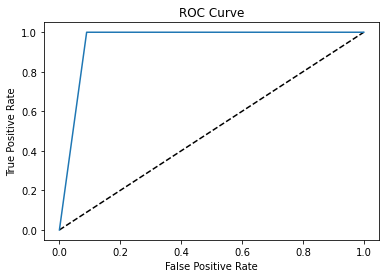

In [42]:
# Generating the ROC curve
y_pred_proba = model_lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# XGBoost Classifier 

**The next classification technique that we are going to use is XGBoost**

In [48]:
XGBoost= XGBClassifier()
XGBoost.fit(X_train, y_train.ravel())
XGBoost.score(X_test, y_test)

0.7071524966261808

**Even after scaling we got an accuracy of 0.7, which right now is pretty average**

In [49]:
model_xgb = XGBClassifier()
model_xgb.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_xgb.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

C:\Users\shahp\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


accuracy score:
0.7004048582995951
confusion matrix: 
[[254 126]
 [ 96 265]]
classification report: 
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       380
           1       0.68      0.73      0.70       361

    accuracy                           0.70       741
   macro avg       0.70      0.70      0.70       741
weighted avg       0.70      0.70      0.70       741



**We can see below that the AUC score is 0.52 and the under the curve as seen is about 52%. This score is worthless and explains that XGBoost model is not efficiently trained. However, we can future try to increase its accuracy**

roc auc is :0.5244751421490013


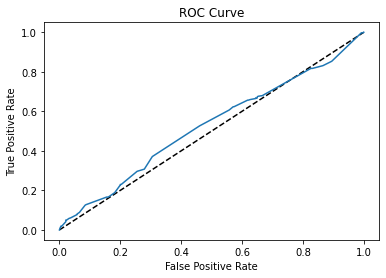

In [50]:
# Generating the ROC curve
y_pred_proba = model_xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

**In order to understand the model well, lets first understand the importance of the features in giving the result**

**As we can see more or less all the features exept the last one are equally responsible for the classification. Hence, in this case it would not be possible for us to use any feature reduction technique**

Feature: 0, Score: 0.09454
Feature: 1, Score: 0.09790
Feature: 2, Score: 0.10927
Feature: 3, Score: 0.09789
Feature: 4, Score: 0.15764
Feature: 5, Score: 0.11463
Feature: 6, Score: 0.11263
Feature: 7, Score: 0.21550
Feature: 8, Score: 0.00000


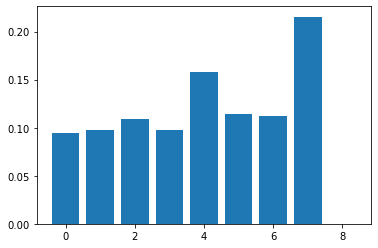

In [51]:
# get importance
importance = model_xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

**We can try to fine tune the model to incease its accuracy The main parameters which can be used for fine tuning the XGBoost model are the n_estimators and the max_depth parameters.**

**Below , we are training the XGBoost classifier on different combinations of max depth and estimators. This output will print out the best parameters as well as the highest accuracy achieved using those parameters**

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib

matplotlib.use('Agg')
model = XGBClassifier()
n_estimators = [150, 200, 250, 450, 500, 550, 1000]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = XGBClassifier(n_estimators=n, max_depth=md)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Score is 0.5303643724696356 at depth of 1 and estimator 150


C:\Users\shahp\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Score is 0.6761133603238867 at depth of 2 and estimator 150
Score is 0.6815114709851552 at depth of 3 and estimator 150
Score is 0.7031039136302294 at depth of 4 and estimator 150
Score is 0.6869095816464238 at depth of 5 and estimator 150
Score is 0.6977058029689609 at depth of 6 and estimator 150
Score is 0.6963562753036437 at depth of 7 and estimator 150
Score is 0.7206477732793523 at depth of 8 and estimator 150
Score is 0.6828609986504723 at depth of 9 and estimator 150
Score is 0.7125506072874493 at depth of 10 and estimator 150
Score is 0.6963562753036437 at depth of 11 and estimator 150
Score is 0.7004048582995951 at depth of 12 and estimator 150
Score is 0.5425101214574899 at depth of 1 and estimator 200
Score is 0.6923076923076923 at depth of 2 and estimator 200
Score is 0.6855600539811066 at depth of 3 and estimator 200
Score is 0.7125506072874493 at depth of 4 and estimator 200
Score is 0.6882591093117408 at depth of 5 and estimator 200
Score is 0.7031039136302294 at depth 

**We can see above that we can get the best accuracy of 0.74 at depth 2 and 1000 estimators**

**Now if we check the ROC curve and AUC, we notice that the model has definetly improved but still not the best we have**

roc auc is :0.7915220877678961


<ipython-input-53-22f1700171f3>:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


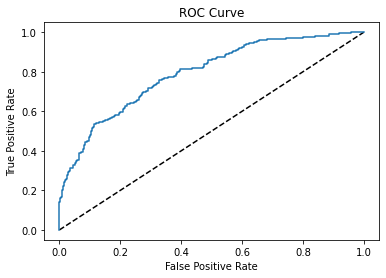

In [53]:
# Generating the ROC curve
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# KNN Classifier

**Further we will classify the data using KNN Classifier**

In [54]:
KNN =KNeighborsClassifier()
KNN.fit(X_train, y_train.ravel())
KNN.score(X_test, y_test)

0.8245614035087719

**It gave a decent accuracy of 0.82**

**But after scaling the accuracy drastically fell to 0.53, which shows that the model is poorly trained and its not worth trying**

In [55]:
model_knn = KNeighborsClassifier()
model_knn.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_knn.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

accuracy score:
0.5317139001349528
confusion matrix: 
[[195 185]
 [162 199]]
classification report: 
              precision    recall  f1-score   support

           0       0.55      0.51      0.53       380
           1       0.52      0.55      0.53       361

    accuracy                           0.53       741
   macro avg       0.53      0.53      0.53       741
weighted avg       0.53      0.53      0.53       741



<ipython-input-55-20b18688dc07>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model_knn.fit(rescaledX, y_train)


roc auc is :0.5


<ipython-input-56-5812c323383c>:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


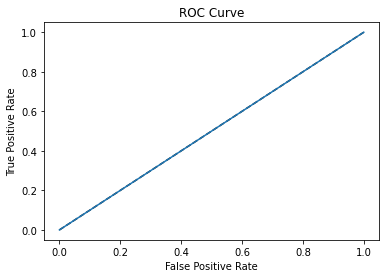

In [56]:
# Generating the ROC curve
y_pred_proba = model_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

**I also tried two other models namely gaussian naive bayes classifier and Decision tree classifier but both gave average accuracies so I did not go through them any further**

In [57]:
NB=GaussianNB()
NB.fit(X_train, y_train.ravel())
NB.score(X_test, y_test)

0.5303643724696356

In [58]:
CART= DecisionTreeClassifier()
CART.fit(X_train, y_train.ravel())
CART.score(X_test, y_test)

0.6072874493927125

# Prediction

**Now, we will try to predict the closing price on the basis of other attributes like neg, neu, pos, compound, Open, High and Low**

In [64]:
merged_data_test=merged_data[['Date','neg','neu','pos','compound','Open','High','Low','Close','Adj Close','Volume']]
merged_data_test.head()

,Date,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.096756,0.831279,0.071965,-0.018231,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0
1,2001-01-03,0.100805,0.812244,0.086976,-0.014800,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0
2,2001-01-04,0.076235,0.838464,0.085294,0.009842,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0
3,2001-01-05,0.098810,0.772841,0.128333,0.028646,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0
4,2001-01-08,0.098348,0.819682,0.081970,-0.055812,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0


In [65]:
X=merged_data_test[['neg','neu','pos','compound','Open','High','Low']]
y=merged_data_test[['Close']]

**Again we will split the data into training set and test set**

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 100)

In [67]:
X_train

,neg,neu,pos,compound,Open,High,Low
773,0.095252,0.817890,0.086867,-0.017382,5356.970215,5450.379883,5324.779785
2346,0.085509,0.856067,0.058428,-0.042479,18080.289060,18260.390630,18050.419920
530,0.135889,0.773545,0.090573,-0.058808,3083.939941,3120.310059,3079.620117
1169,0.143306,0.758190,0.098497,-0.047420,8066.060059,8084.790039,7922.890137
682,0.124117,0.784343,0.091540,-0.046755,5071.200195,5092.700195,4965.500000
...,...,...,...,...,...,...,...
350,0.119815,0.800809,0.079380,-0.059222,3356.850098,3361.919922,3343.100098
1930,0.117769,0.775243,0.107002,-0.016978,8400.879883,8540.459961,8316.389648
79,0.079456,0.868351,0.052167,-0.030056,3674.419922,3700.879883,3648.360107
1859,0.130474,0.796380,0.073146,-0.067947,14594.639650,14725.940430,14503.509770


**For prediction of closing values I have used here Random forest Regression**

In [68]:
from sklearn.ensemble import RandomForestRegressor 
  
 # create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, y_train)  


<ipython-input-68-78cd9e10659a>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


RandomForestRegressor(random_state=0)

In [69]:
y_pred=regressor.predict(X_test)

In [76]:
y_pred

array([ 9341.18500981,  9112.76667004, 19001.7743748 ,  9260.99678726,
       10662.2054296 ,  3660.43164315,  3374.77620848, 14960.5267202 ,
        2954.01099607, 10754.4290042 ,  3186.49049814, 12384.1591793 ,
        9557.00854488,  5219.19743166, 19126.466817  ,  3234.42154056,
        4089.74052983, 17256.7554314 ,  3157.76613765, 14164.3533786 ,
       15017.3540425 ,  3318.22010258, 19673.3792774 , 11028.3738088 ,
       10886.5382912 ,  3757.34819563,  8634.50984359,  3390.69410885,
       14327.3927441 , 12972.9807807 ,  5850.43488293,  3334.62858407,
       12236.1561908 , 13004.5273429 , 16645.4208892 , 15056.9351184 ,
       19507.6046291 ,  5821.68445325, 17516.7157208 ,  5391.64436509,
       14037.9122852 ,  6361.29415518, 17570.3757835 , 13366.5855264 ,
       17264.9808606 ,  3228.23720966,  4212.69780011,  5198.68675781,
        9328.47503905, 20332.6079297 , 15761.6770906 , 15322.2998051 ,
        6472.42579101,  6533.49688958,  4286.0279833 ,  3233.46631107,
      

In [78]:
y_test

,Close
1967,9329.570313
1963,9071.360352
1706,19091.960940
1980,9300.860352
1260,10735.360350
...,...
1844,13330.509770
1263,10573.540040
918,5679.830078
2288,16022.480470


In [79]:
y_true= y_test['Close'].tolist()

**As you can see here I've compared the expected values and predicted values. Clearly, there is not much difference between the two and can easily be considered good enough for making statergic decisions while buying stocks**

In [82]:
for x in range(len(y_test)):
    print("expected value:"+ str(y_true[x]) + "Predicted value:" + str(y_pred[x]))

expected value:9329.570313Predicted value:9341.185009810002
expected value:9071.360352Predicted value:9112.766670040002
expected value:19091.96094Predicted value:19001.77437480002
expected value:9300.860352Predicted value:9260.996787259986
expected value:10735.36035Predicted value:10662.205429600004
expected value:3712.73999Predicted value:3660.431643150001
expected value:3384.199951Predicted value:3374.7762084799992
expected value:14964.12012Predicted value:14960.526720200003
expected value:2966.629883Predicted value:2954.010996070002
expected value:10803.86035Predicted value:10754.429004200001
expected value:3215.23999Predicted value:3186.4904981400014
expected value:12372.80957Predicted value:12384.159179299997
expected value:9645.459961Predicted value:9557.008544880002
expected value:5210.850098Predicted value:5219.197431659996
expected value:18969.44922Predicted value:19126.46681700002
expected value:3247.51001Predicted value:3234.4215405600016
expected value:4069.679932Predicted 

**The mean squared error of the model training is about 10332 which is considerably good as we are dealing with a huge set of numbers.**

In [71]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 63.71096724388688
Mean Squared Error: 10332.548418135804
Root Mean Squared Error: 101.6491437157038


# In total we have an Logistic Regression model which has an accuracy of 95%, XGBoost model with an accuracy of 74% and a Random Forest Regression which can be used to predict the actual prices.